This notebook walks through a few examples that show how to use `triceratops`. The examples below show:

1. How to apply `triceratops` on a star observed in a $\textbf{single}$ ${\it Kepler}$ quarter $\textbf{without}$ follow up data.

In [2]:
import lightkurve
import numpy as np
import pandas as pd
import time
from lightkurve import TessLightCurve
import matplotlib.pyplot as plt
from scipy import stats
import triceratops.triceratops as tr
import sys

%matplotlib inline
print(sys.version)

3.8.0 (default, Feb 25 2021, 22:10:10) 
[GCC 8.4.0]


## Example initialization

First, let's apply the tool on Kepler KIC 12557548b, which was observed with a 1 minute cadence in quarter 13.

Begin by defining the target star object with the `target(ID, sectors)` class. The arguments for this class are `ID` (the KIC ID of the star) and `sectors` (the quarters in which the star was observed). `ID` should be an integer and `sectors` should be a numpy array.


In [3]:
ID = 12557548
sectors = np.array([13])
# tpf_search_results = lightkurve.search_targetpixelfile("KIC " + str(ID), mission="Kepler",
#                                                                        cadence=60, quarter=sectors).download_all()
# tpf_search_results[0].plot()
# plt.show()
target = tr.target(ID=ID, sectors=sectors, mission="Kepler")

Next, let's define the aperture used to extract the light curve, plot an image of the field, and display a table of nearby stars.

The aperture should be a 2D numpy array with the formal `[[col#, row#], [col#, row#], [col#, row#], ...]`, where where each `[col#, row#]` is the column and row number of the pixel.

An image of the field can be plotted with the `.plot_field(sector, ap_pixels)` method. This method takes as optional arguments `sector` (the image sector you would like to plot) and `ap_pixels` (the aperture we just defined).

We can display a table of the stars in the image with the `.stars` attribute. This table contains the separation and position angle of each star from the target star, so that each can be identified in the plot.

Note that the scale of a TESS pixel is about 20 arcseconds and a Kepler/K2 pixel is about 4.

In [4]:
ap = np.array([[99, 1027], [100, 1027], [100, 1026]])
#TODO plot_field doesn't work yet with kepler
# target.plot_field(sector=13, ap_pixels=ap)
 
target.stars

,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N)
0,417679385,14.9870,14.021,13.433,13.319,290.966208,51.504718,0.72,0.734657,4571.0,1.616660,0.000,0.000
1,1883233182,19.7210,NaN,NaN,NaN,290.963775,51.507358,NaN,NaN,NaN,1.432040,10.957,330.165
2,1883233178,18.6002,NaN,NaN,NaN,290.961274,51.505510,NaN,NaN,4878.0,0.208458,11.417,284.463
3,417679388,18.2929,16.267,15.660,15.497,290.964020,51.508152,0.42,0.459376,3438.0,1.292760,13.301,338.375
4,1883233179,20.0049,NaN,NaN,NaN,290.977604,51.505828,NaN,NaN,NaN,-0.981721,25.847,81.098
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,1883233081,19.6914,NaN,NaN,NaN,291.019155,51.459540,NaN,NaN,NaN,-0.823559,201.349,143.855
273,417655542,18.1411,16.402,16.010,15.367,290.880199,51.488323,0.62,1.012110,3956.0,0.226682,201.597,253.010
274,1883233145,19.5011,NaN,NaN,NaN,290.891611,51.473424,NaN,NaN,4746.0,-0.629688,201.626,236.060
275,417679448,15.8598,15.140,14.794,14.687,290.953937,51.560420,1.03,1.502750,5762.0,0.307535,202.403,352.202


We can now determine which stars in the aperture are bright enough to produce the observed transit. The transit for this TOI has a depth of ~5000 ppm. We'll use the `.calc_depths(tdepth, all_ap_pixels)` method to do this. This method takes as arguments `tdepth` (the transit depth of the candidate) and `all_ap_pixels` (a numpy array of all apertures). After doing this, the `.stars` table includes the flux ratio contributed by each star in the aperture and the transit depth each star would have if it were the host of the signal.

In [5]:
apertures = np.array([ap])
target.calc_depths(tdepth=0.004595, all_ap_pixels=apertures)
target.stars

/home/martin/git_repositories/triceratops_fork/triceratops/triceratops.py:480: RuntimeWarning: overflow encountered in double_scalars
  tdepths[i] = 1-(flux_ratios[i]-tdepth)/flux_ratios[i]


,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N),fluxratio,tdepth
0,417679385,14.9870,14.021,13.433,13.319,290.966208,51.504718,0.72,0.734657,4571.0,1.616660,0.000,0.000,9.994198e-01,0.004598
1,1883233182,19.7210,NaN,NaN,NaN,290.963775,51.507358,NaN,NaN,NaN,1.432040,10.957,330.165,2.675706e-04,0.000000
2,1883233178,18.6002,NaN,NaN,NaN,290.961274,51.505510,NaN,NaN,4878.0,0.208458,11.417,284.463,2.024918e-04,0.000000
3,417679388,18.2929,16.267,15.660,15.497,290.964020,51.508152,0.42,0.459376,3438.0,1.292760,13.301,338.375,1.101000e-04,0.000000
4,1883233179,20.0049,NaN,NaN,NaN,290.977604,51.505828,NaN,NaN,NaN,-0.981721,25.847,81.098,1.995740e-13,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,1883233081,19.6914,NaN,NaN,NaN,291.019155,51.459540,NaN,NaN,NaN,-0.823559,201.349,143.855,0.000000e+00,0.000000
273,417655542,18.1411,16.402,16.010,15.367,290.880199,51.488323,0.62,1.012110,3956.0,0.226682,201.597,253.010,0.000000e+00,0.000000
274,1883233145,19.5011,NaN,NaN,NaN,290.891611,51.473424,NaN,NaN,4746.0,-0.629688,201.626,236.060,0.000000e+00,0.000000
275,417679448,15.8598,15.140,14.794,14.687,290.953937,51.560420,1.03,1.502750,5762.0,0.307535,202.403,352.202,0.000000e+00,0.000000


After doing this, we can calculate the probability of each scenario using the `.calc_prob(time, flux_0, flux_err_0, P_orb)` method, which requires as arguments `time` (times from phase-folded light curve in units of days from transit center), `flux_0` (normalized flux from phase-folded light curve), `flux_err_0` (flux error values of the target's phase-folded light curve), and `P_orb` (orbital period of the TOI in days).

If you have a lot of data points, I recommend binning your light curve down to ~100 to save time. Binning your data is poor practice when fitting light curves for a planet's parameters, but it doesn't yield significantly different results for our purposes. This should only take a few minutes.

In [6]:
%%time

P_orb = 0.6535777389077114
# read in the light curve
lc = pd.read_csv("KIC12557548.csv", header=0)
time, flux, flux_err = lc["#time"].values, lc["flux"].values, lc["flux_err"].values
lc_len = len(time)
zeros_lc = np.zeros(lc_len)
lc = TessLightCurve(time=time, flux=flux, flux_err=flux_err, quality=zeros_lc)
lc.extra_columns = []
lc = lc.fold(period=P_orb, epoch_time=1182.9703010131273, normalize_phase=True)
duration_days = 90 / 60 / 24
folded_plot_range = duration_days / 2 / P_orb * 5
inner_folded_range_args = np.where((0 - folded_plot_range < lc.time.value) & (lc.time.value < 0 + folded_plot_range))
lc = lc[inner_folded_range_args]
lc.time = lc.time * P_orb
bin_means, bin_edges, binnumber = stats.binned_statistic(lc.time.value, lc.flux.value, statistic='mean', bins=500)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width / 2

<timed exec>:8: UserWarning: Lightkurve doesn't allow columns or meta values to be created via a new attribute name.A new attribute is created. It will not be carried over when the object is copied. - see https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html


CPU times: user 2min 34s, sys: 69.3 ms, total: 2min 34s
Wall time: 2min 34s


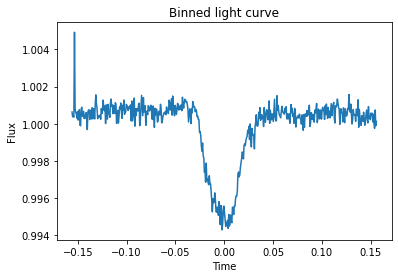

In [9]:
plt.plot(bin_centers, bin_means)
plt.title("Binned light curve")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

In [ ]:
target.calc_probs(time=bin_centers, flux_0=bin_means, flux_err_0=np.mean(lc.flux_err.value), P_orb=P_orb)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Now that that's done, let's check out a table of our results with the `.probs` attribute and calculate the false positive probability and nearby false positive probability using the `.FPP`  and `.NFPP` attributes. We expect a scatter of a few percent in our probabilities, so don't be alarmed if it's slightly different with each run. We can also plot the transit fits of each scenario using the `.plot_fits(time, flux_0, flux_err_0)` method.

In [7]:
df_results = target.probs
print("FPP =", np.round(target.FPP, 4))
print("NFPP =", np.round(target.NFPP, 4))
df_results

FPP = 0.0257
NFPP = 0.0


,ID,scenario,M_s,R_s,P_orb,inc,ecc,w,R_p,M_EB,R_EB,prob
0,270380593,TP,0.811000,0.847380,3.836169,88.333097,0.113006,113.614711,6.247005,0.000000,0.000000,8.969353e-01
1,270380593,EB,0.811000,0.847380,3.836169,81.575924,0.248700,18.816670,0.000000,0.750206,0.780463,0.000000e+00
2,270380593,EBx2P,0.811000,0.847380,7.672338,86.732359,0.440551,272.710761,0.000000,0.802865,0.829755,2.788198e-42
3,270380593,PTP,0.811000,0.847380,3.836169,87.434474,0.013503,313.670909,6.689277,0.000000,0.000000,7.212812e-02
4,270380593,PEB,0.811000,0.847380,3.836169,85.730594,0.003117,273.231842,0.000000,0.100772,0.121108,8.221751e-281
5,270380593,PEBx2P,0.811000,0.847380,7.672338,86.700629,0.434983,285.997552,0.000000,0.775086,0.803671,1.607920e-37
6,270380593,STP,0.798209,0.825326,3.836169,88.325342,0.240162,166.823432,8.882569,0.000000,0.000000,2.565628e-02
7,270380593,SEB,0.645203,0.667594,3.836169,89.535783,0.046837,341.811599,0.000000,0.085054,0.100000,3.151474e-14
8,270380593,SEBx2P,0.208363,0.237596,7.672338,89.400395,0.475742,252.902277,0.000000,0.200939,0.230855,1.641204e-44
9,270380593,DTP,0.811000,0.847380,3.836169,88.067831,0.284716,8.442403,6.457548,0.000000,0.000000,5.280339e-03


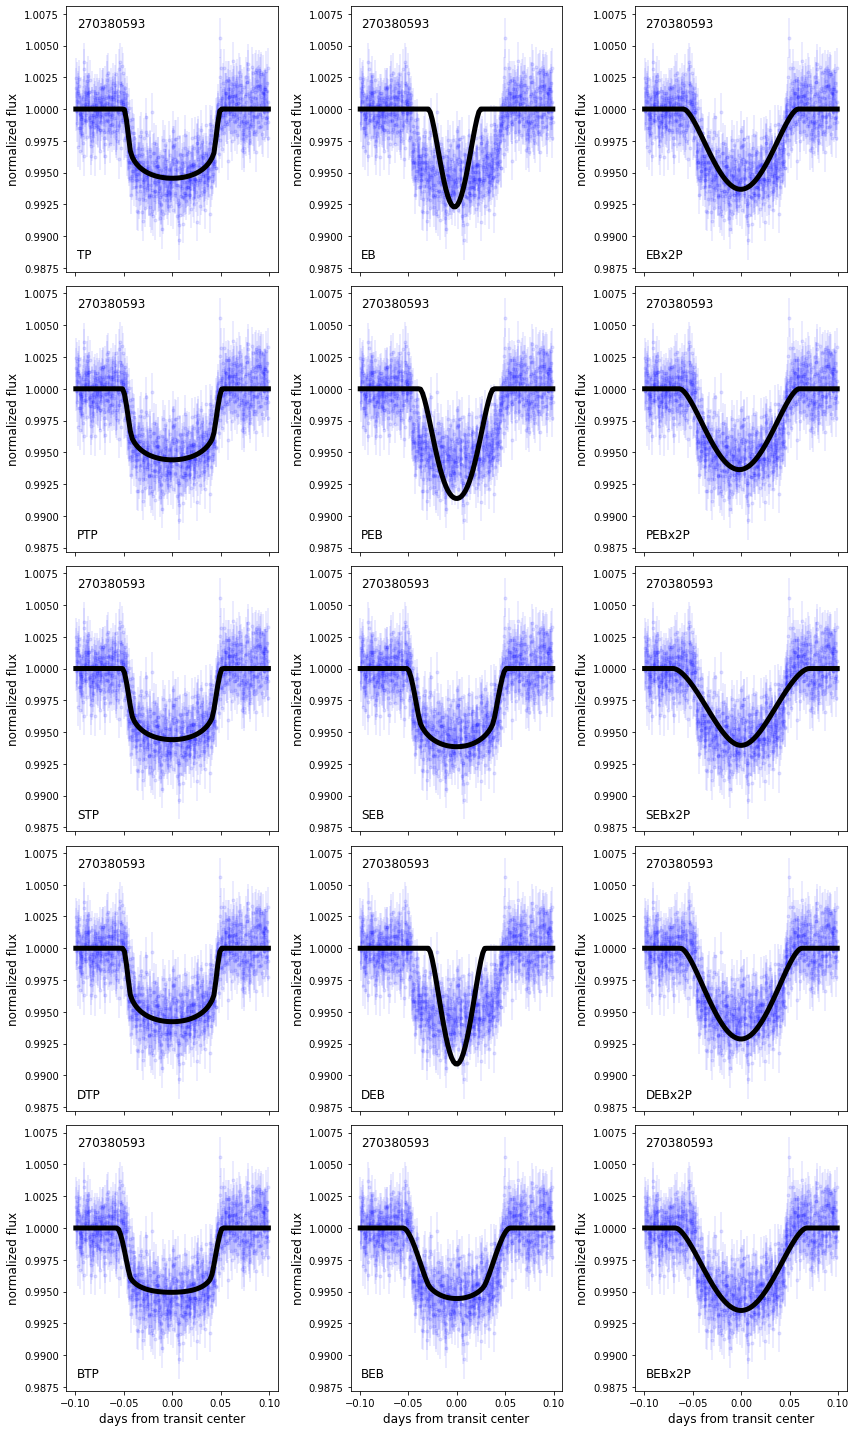

In [8]:
target.plot_fits(time=time, flux_0=flux, flux_err_0=np.mean(flux_err))